In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')




In [98]:
import pandas as pd

df = pd.read_csv("hour.csv")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


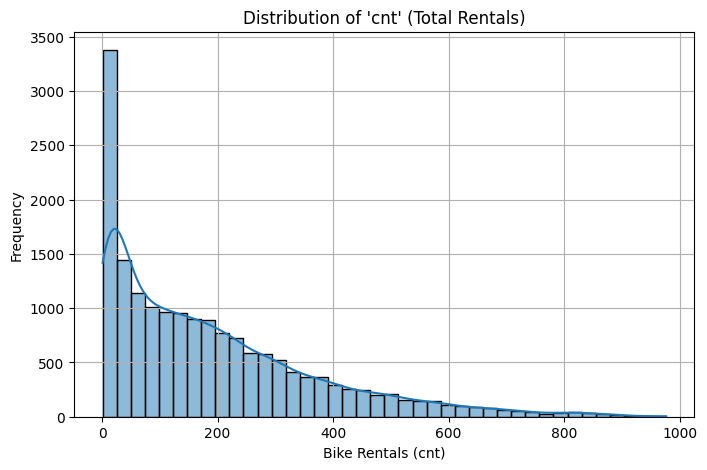

Skewness of 'cnt': 1.28


In [99]:
# Distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(df['cnt'], bins=40, kde=True)
plt.title("Distribution of 'cnt' (Total Rentals)")
plt.xlabel("Bike Rentals (cnt)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Skewness
cnt_skewness = df['cnt'].skew()
print(f"Skewness of 'cnt': {cnt_skewness:.2f}")


Right skewed distriutions
most of the data is concentrated on the left side,
There are lot of instances with rentals between 0 and 100.
There are some instances where rentals go above 600 plus ,indicating those are rare high demand hours.


Peak hours get very high rentals.
Because the data is not normally distributed,some models like linear regression might not perform as well unless we use models that are robust to skewed targets (like Random Forest, XGBoost).

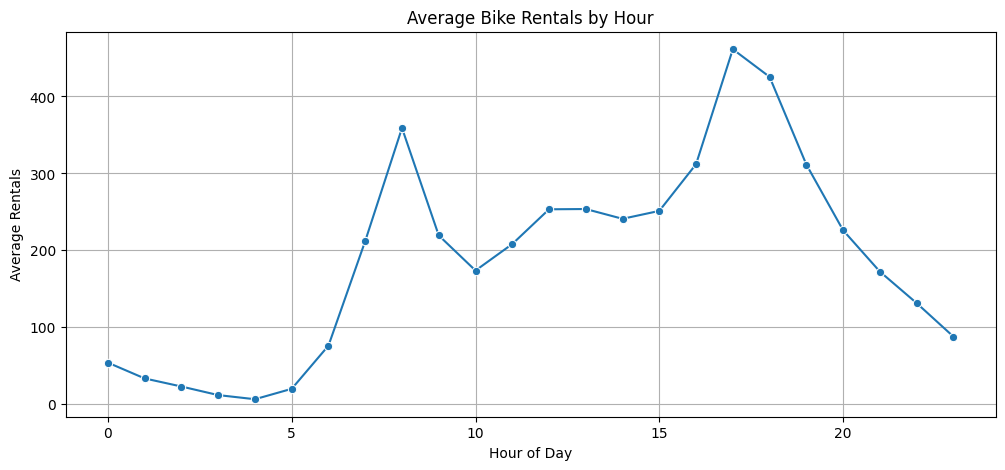

In [100]:
# Average rentals by hour
plt.figure(figsize=(12, 5))
sns.lineplot(data=df.groupby("hr")["cnt"].mean(), marker="o")
plt.title("Average Bike Rentals by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Rentals")
plt.grid(True)
plt.show()



X-axis: Bike Rentals (cnt)
Y-axis: Frequency (number of observations)

Interpretation:
The spread is skewed to the right, which suggests that rental counts are mostly low.Large numbers of the instances have rental counts between (0,100), peaking very early.
As the number of rentals increases, the frequency decreases sharply.The implication is that rented hours are generally not very high, but could still be very high (long tail).

Implication for modeling:
This distribution can be transformed (as log) and may be beneficial when using linear models.we may notice that with tree-based models, like Random Forest or XGBoost, skewed distributions aren’t much of a problem.

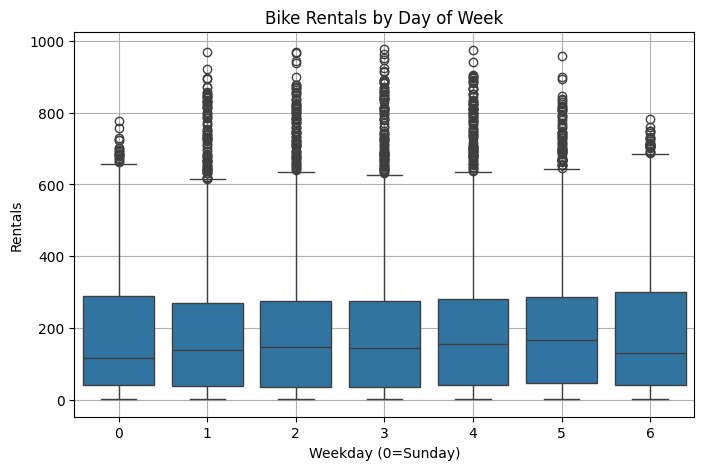

In [101]:
# Boxplot by weekday
plt.figure(figsize=(8, 5))
sns.boxplot(x="weekday", y="cnt", data=df)
plt.title("Bike Rentals by Day of Week")
plt.xlabel("Weekday (0=Sunday)")
plt.ylabel("Rentals")
plt.grid(True)
plt.show()

X-axis: Hour of Day (0 to 23)
Y-axis: Average Rentals

Interpretation:

There are two clear rental peaks:
Morning peak (8 AM): This is probably the time when people are commuting to work or school.
Evening peak (5–6 PM): Represents people returning home.
Between the hours of 2 AM and 5 AM is when rental activity is at its lowest - likely reflecting common sleep times.
The time-of-day effect on rentals is clearly evident.

Implication for modeling:

Hour is a highly informative feature.
Could potentially gain from things like feature engineering such as creating binary rush hour feature; e.g., 7 to 9 AM and 5 to 9 PM

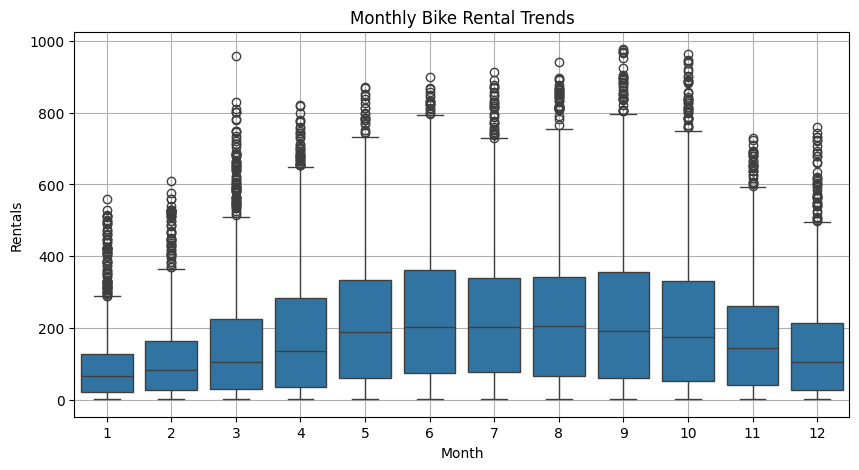

In [102]:
# Rentals by month
plt.figure(figsize=(10, 5))
sns.boxplot(x="mnth", y="cnt", data=df)
plt.title("Monthly Bike Rental Trends")
plt.xlabel("Month")
plt.ylabel("Rentals")
plt.grid(True)
plt.show()

The box plot chart shows "Monthly Bike Rental Trends". It represents the range of bicycle rentals made in each month of the year from January (1) to December (12). Y represents the count of rentals, ranging from 0 to 1000.

Each box plot portrays a monthly summary:
-Median: The mark above the body of the box, showing the rental that is closest to the middle.
Quartiles - The box edges display the range between the 25th and 75th percentiles.
Outliers denote the points outside the whiskers, visualizing unusual rental counts.

The chart illustrates the seasonal nature of rentals, more active months are exchanged with less active ones. The chart is useful for recognizing the trends, understanding in which season bikes are most popular and understanding the months with the most unusual rental patterns.

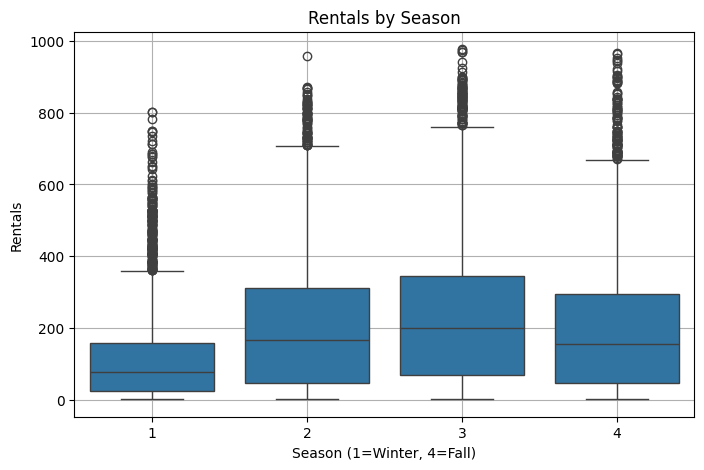

In [103]:

# Rentals by season
plt.figure(figsize=(8, 5))
sns.boxplot(x="season", y="cnt", data=df)
plt.title("Rentals by Season")
plt.xlabel("Season (1=Winter, 4=Fall)")
plt.ylabel("Rentals")
plt.grid(True)
plt.show()

This box plots shows the rentals of bike in each season

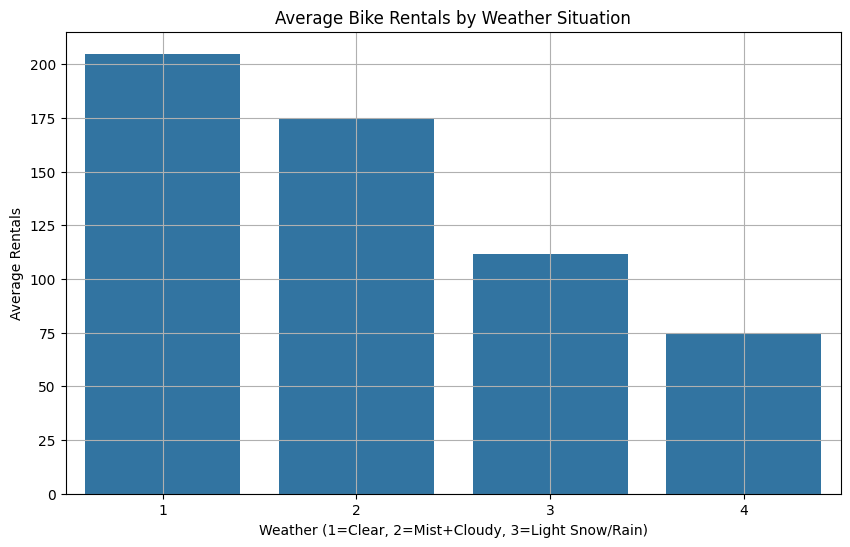

In [104]:
# Weather analysis
plt.figure(figsize=(10, 6))
weather_rentals = df.groupby('weathersit')['cnt'].mean()
sns.barplot(x=weather_rentals.index, y=weather_rentals.values)
plt.title('Average Bike Rentals by Weather Situation')
plt.xlabel('Weather (1=Clear, 2=Mist+Cloudy, 3=Light Snow/Rain)')
plt.ylabel('Average Rentals')
plt.grid(True)
plt.show()

The histogram shows the average bike rentals during each weather situation.we can see that when weather is clear the avg bike rentals is high and when the weather is lightsnow or rain the avg bike rentals id low.

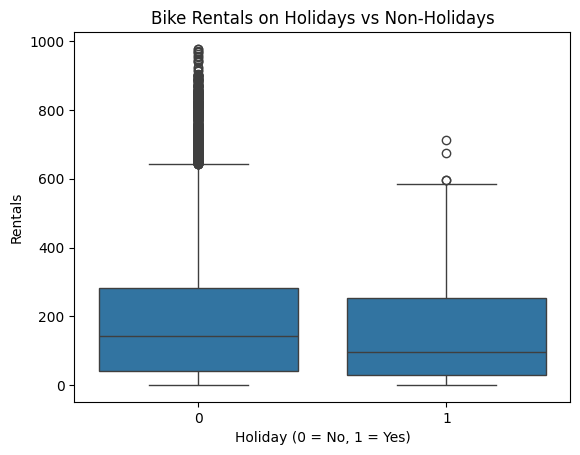

In [105]:
# Holiday vs Non-holiday
sns.boxplot(x="holiday", y="cnt", data=df)
plt.title("Bike Rentals on Holidays vs Non-Holidays")
plt.xlabel("Holiday (0 = No, 1 = Yes)")
plt.ylabel("Rentals")
plt.show()


when there is no holiday the rental of bike is high

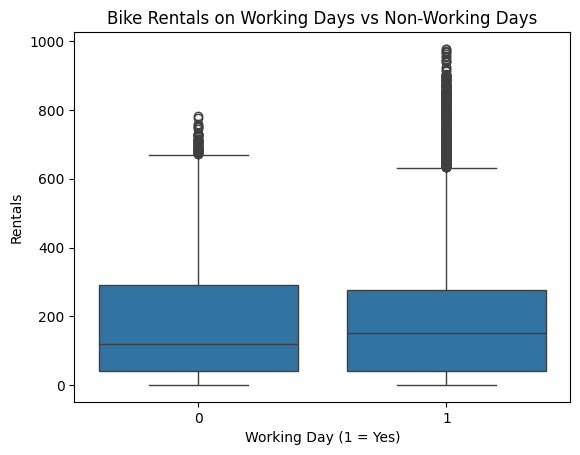

In [106]:
# Working day vs Weekend/holiday
sns.boxplot(x="workingday", y="cnt", data=df)
plt.title("Bike Rentals on Working Days vs Non-Working Days")
plt.xlabel("Working Day (1 = Yes)")
plt.ylabel("Rentals")
plt.show()

when it a working day the rental is high

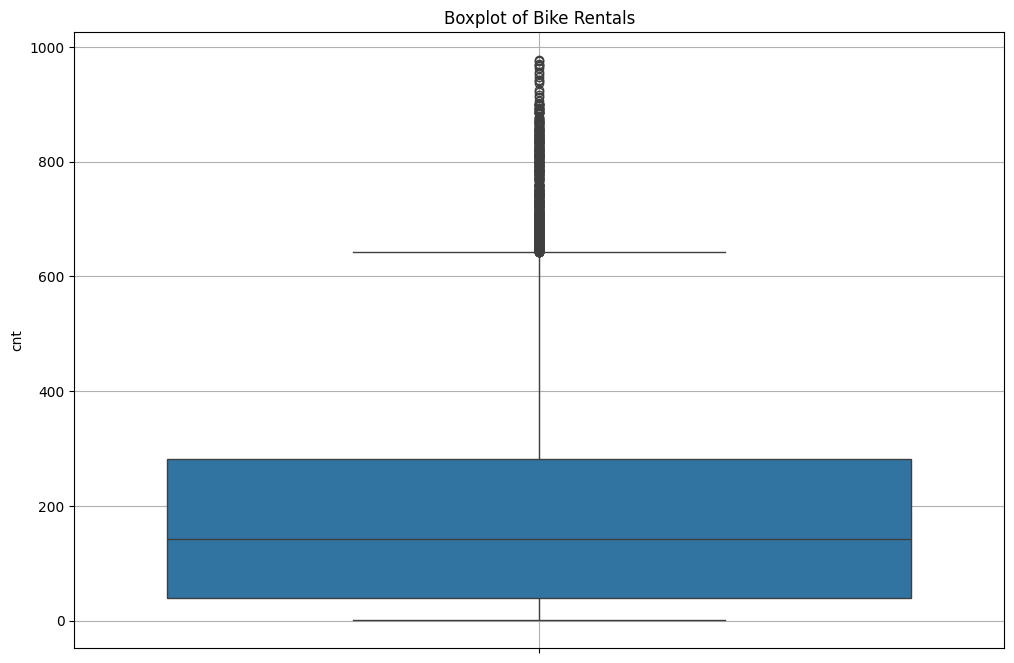

In [107]:
# Outliers detection
plt.figure(figsize=(12, 8))
sns.boxplot(df['cnt'])
plt.title('Boxplot of Bike Rentals')
plt.grid(True)
plt.show()

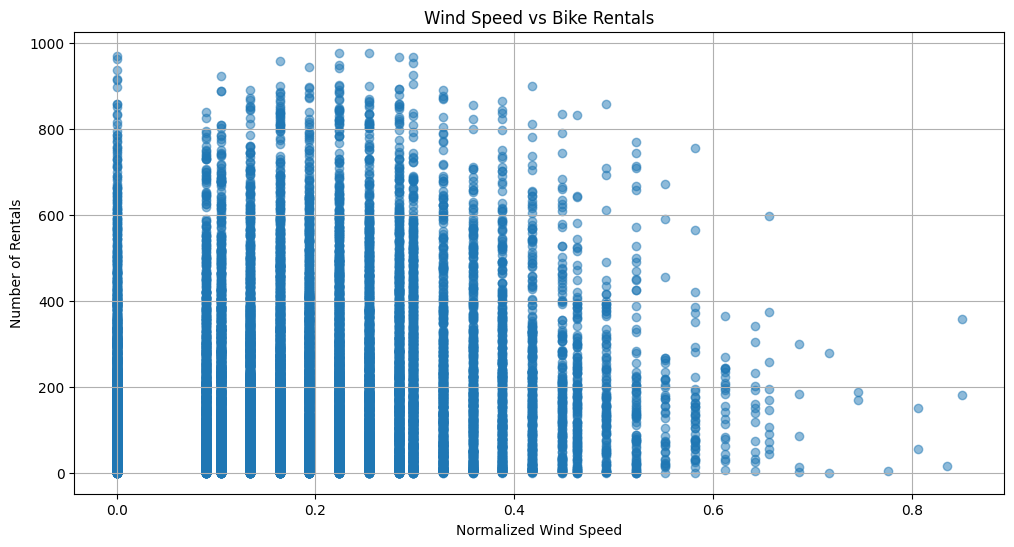

In [108]:


# Wind speed vs rentals
plt.figure(figsize=(12, 6))
plt.scatter(df['windspeed'], df['cnt'], alpha=0.5)
plt.title('Wind Speed vs Bike Rentals')
plt.xlabel('Normalized Wind Speed')
plt.ylabel('Number of Rentals')
plt.grid(True)
plt.show()




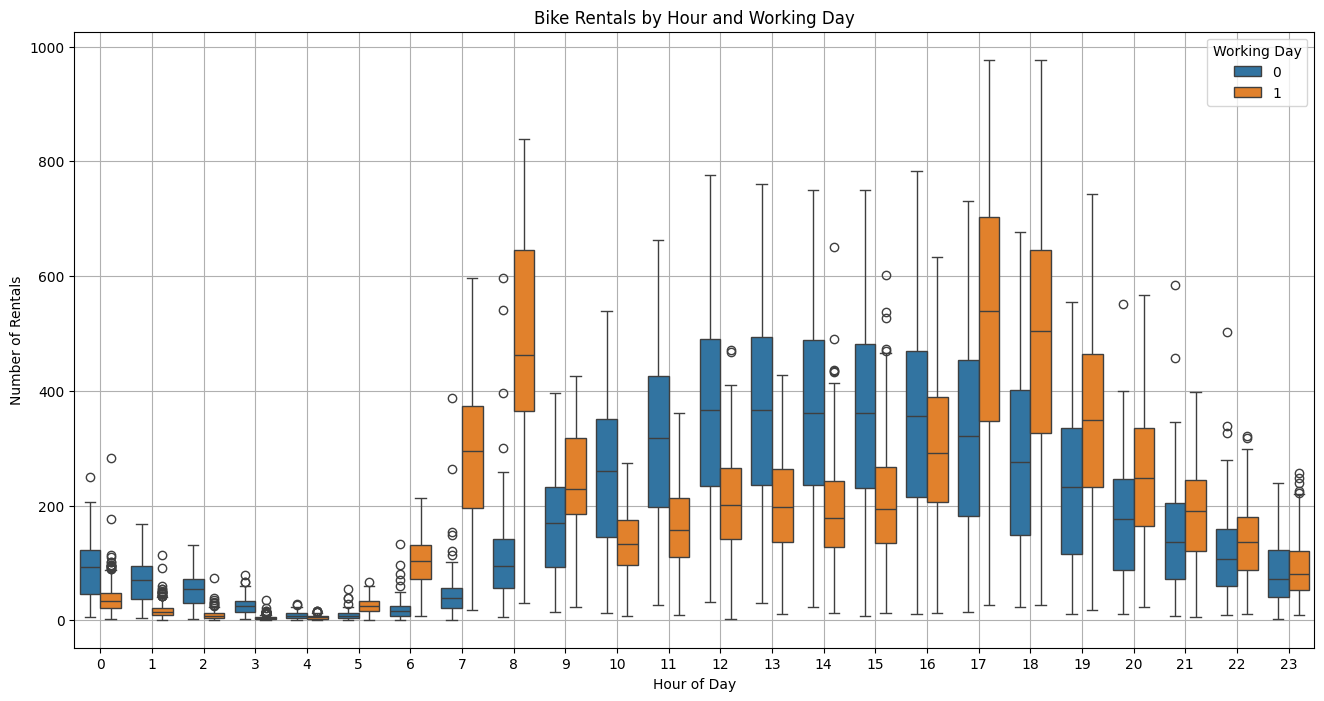

In [109]:
# Boxplot of rentals by hour and workingday
plt.figure(figsize=(16, 8))
sns.boxplot(x='hr', y='cnt', hue='workingday', data=df)
plt.title('Bike Rentals by Hour and Working Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rentals')
plt.legend(title='Working Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

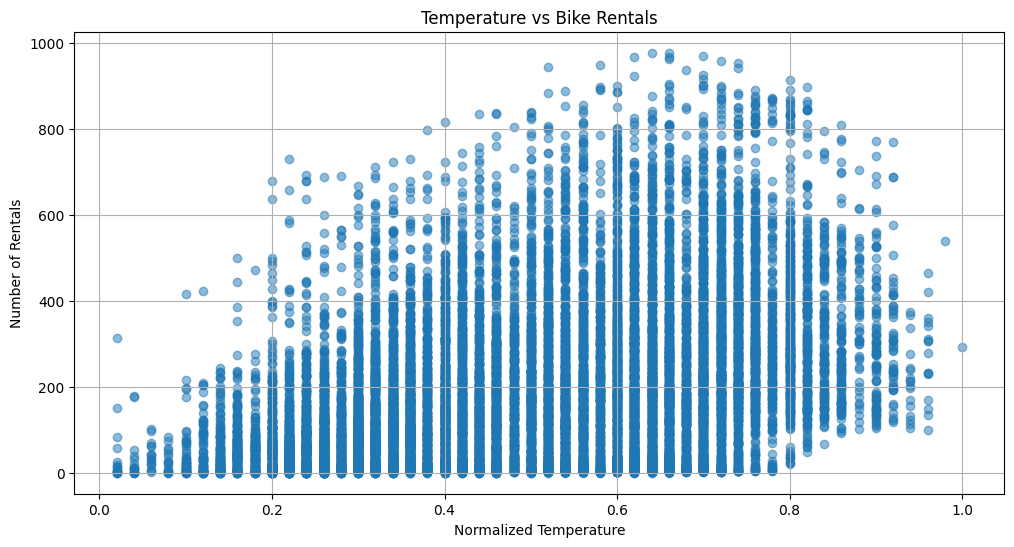

In [110]:
# Temperature vs rentals
plt.figure(figsize=(12, 6))
plt.scatter(df['temp'], df['cnt'], alpha=0.5)
plt.title('Temperature vs Bike Rentals')
plt.xlabel('Normalized Temperature')
plt.ylabel('Number of Rentals')
plt.grid(True)
plt.show()

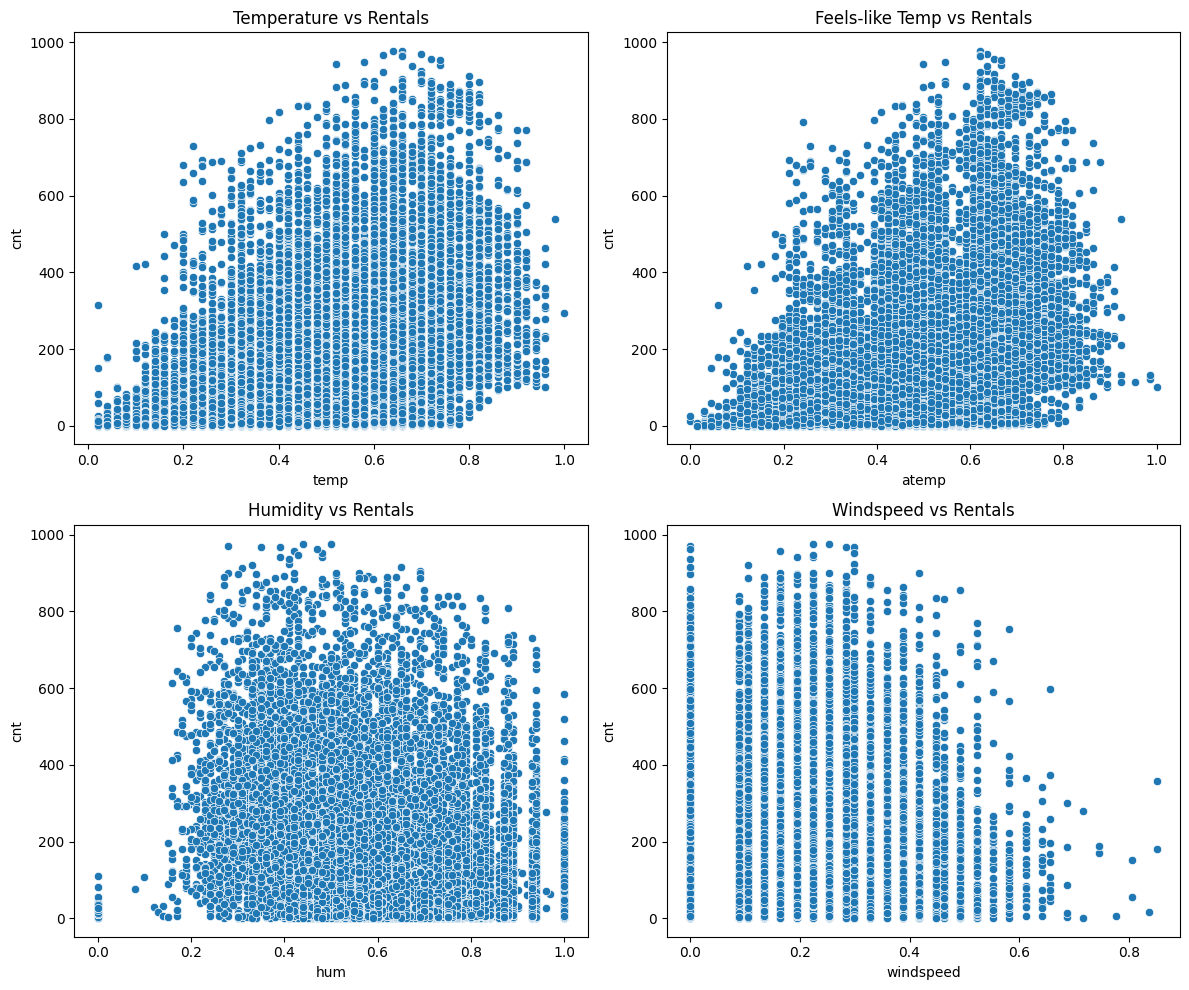

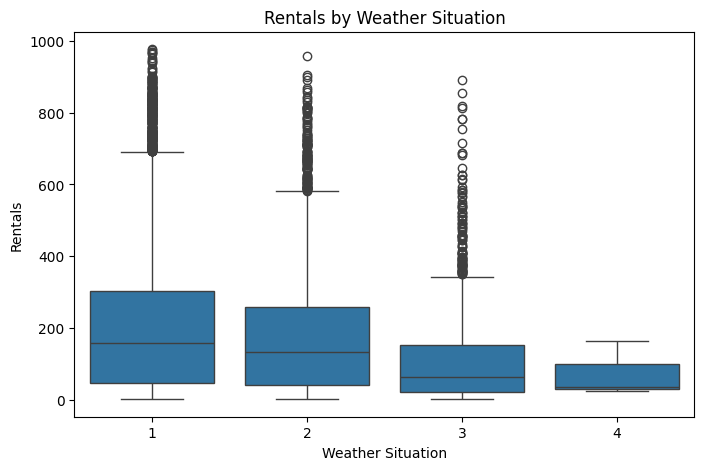

In [111]:
# Scatterplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x="temp", y="cnt", data=df, ax=axs[0, 0])
axs[0, 0].set_title("Temperature vs Rentals")

sns.scatterplot(x="atemp", y="cnt", data=df, ax=axs[0, 1])
axs[0, 1].set_title("Feels-like Temp vs Rentals")

sns.scatterplot(x="hum", y="cnt", data=df, ax=axs[1, 0])
axs[1, 0].set_title("Humidity vs Rentals")

sns.scatterplot(x="windspeed", y="cnt", data=df, ax=axs[1, 1])
axs[1, 1].set_title("Windspeed vs Rentals")

plt.tight_layout()
plt.show()

# Weather situation
plt.figure(figsize=(8, 5))
sns.boxplot(x="weathersit", y="cnt", data=df)
plt.title("Rentals by Weather Situation")
plt.xlabel("Weather Situation")
plt.ylabel("Rentals")
plt.show()


In [112]:
# Simple way to see outliers
df.describe()

# Optional: Z-score filtering or IQR method to detect extreme outliers


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [113]:
# Check if columns exist before dropping
columns_to_drop = ["instant", "dteday", "casual", "registered"]
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Now drop only the existing columns
df.drop(columns=columns_to_drop, inplace=True)
df.head()


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


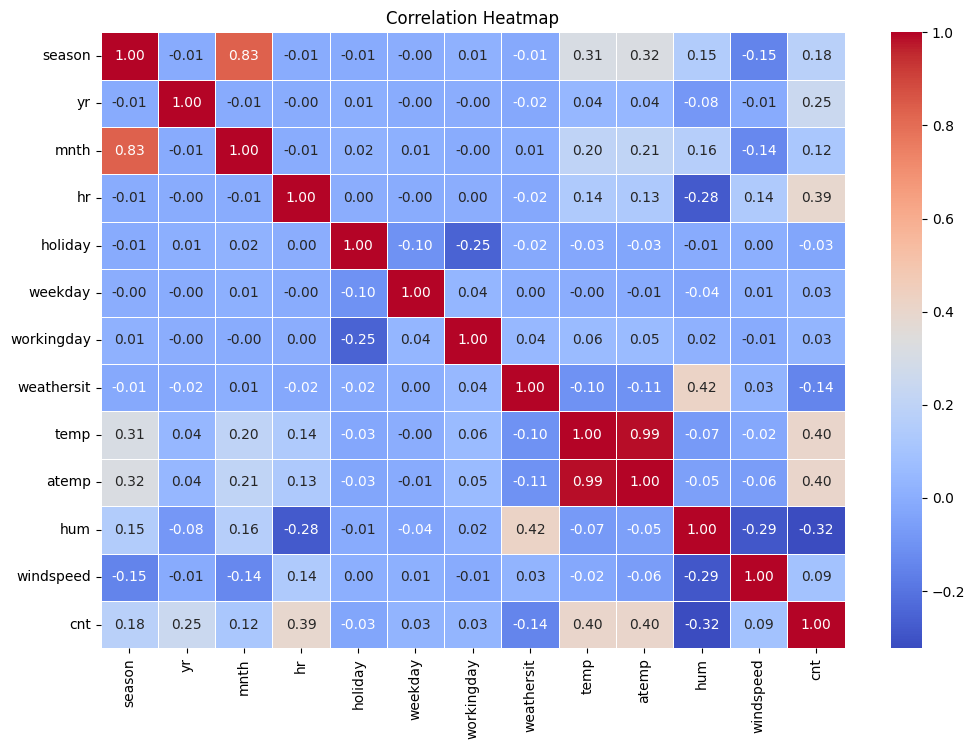

In [114]:
import numpy as np

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [115]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Re-load the original CSV to get back dteday
df_ts = pd.read_csv("hour.csv")

# Create a proper datetime index
df_ts["datetime"] = pd.to_datetime(df_ts["dteday"]) + pd.to_timedelta(df_ts["hr"], unit='h')
df_ts.set_index("datetime", inplace=True)

# Resample hourly to daily totals for cleaner decomposition
daily_cnt = df_ts['cnt'].resample('D').sum()


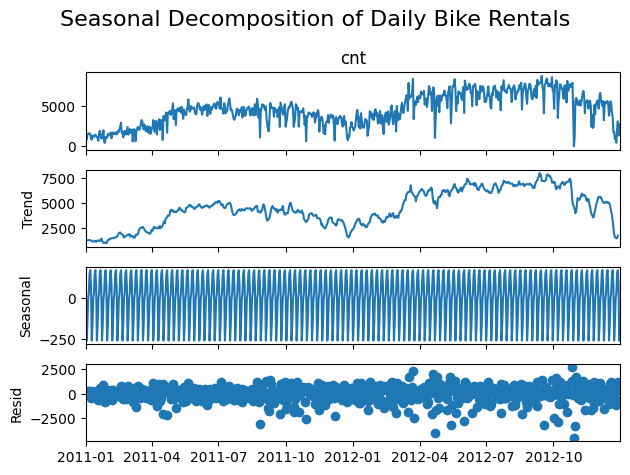

In [116]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(daily_cnt, model='additive', period=7)  # Weekly cycle

# Plot components
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Daily Bike Rentals", fontsize=16)
plt.tight_layout()
plt.show()


Data splitting


we spilt the data before feature engineering to avoid data leakage.

In [117]:
# 4. IMPROVED DATA SPLITTING - Time-based with gap for better generalization
# Sort by time to maintain temporal order
df = df.sort_values(by=['yr', 'mnth', 'hr']).reset_index(drop=True)

# Time-based train/val/test split with small gaps between sets
n = len(df)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

# Add small gaps between train, val, and test to better evaluate generalization
train_df = df.iloc[:train_end-24].copy()  # End 24h before validation starts
val_df = df.iloc[train_end:val_end-24].copy()  # Start where training ended, end 24h before test
test_df = df.iloc[val_end:].copy()  # Start where validation ended

print(f"Train: {len(train_df)} rows | Val: {len(val_df)} rows | Test: {len(test_df)} rows")

Train: 10403 rows | Val: 3452 rows | Test: 3476 rows


Feature engineering


In [118]:
def encode_cyclical_features(data):
    """Encode cyclical features using sine and cosine transformations"""
    data = data.copy()

    # Hour of day (0-23)
    data['hr_sin'] = np.sin(2 * np.pi * data['hr']/24)
    data['hr_cos'] = np.cos(2 * np.pi * data['hr']/24)

    # Day of week (0-6)
    data['weekday_sin'] = np.sin(2 * np.pi * data['weekday']/7)
    data['weekday_cos'] = np.cos(2 * np.pi * data['weekday']/7)

    # Month (1-12)
    data['month_sin'] = np.sin(2 * np.pi * (data['mnth']-1)/12)
    data['month_cos'] = np.cos(2 * np.pi * (data['mnth']-1)/12)

    return data




The function encode_cyclical_features() is used to turn time-based cyclical variables—such as hour of day, day of week, and month—into sine and cosine components.

 This is useful because, for example, hour 0 and hour 23 are numerically far apart but temporally adjacent, and most machine learning models would be misled if they were simply treated as integers.

 The sine and cosine transformations place all time-based features on a circle, which makes it possible for tree-based models like Random Forest and Gradient Boosting to learn the time-related trends better without having to interpret the variables as linear.

 The result of encoding the features in this manner is improved performance and interpretability of the model.

In [119]:
def create_interaction_features(data):
    """
    Create interaction features that might be useful for prediction
    based on domain knowledge and EDA insights
    """
    data = data.copy()

    # Temperature and humidity interaction (justified by EDA)
    data['temp_hum'] = data['temp'] * data['hum']

    # Temperature and windspeed interaction
    data['temp_wind'] = data['temp'] * data['windspeed']

    # Humidity and windspeed interaction
    data['hum_wind'] = data['hum'] * data['windspeed']

    # Create peak hours feature (commute times)
    data['is_peak_hour'] = ((data['hr'] >= 7) & (data['hr'] <= 9) |
                           (data['hr'] >= 16) & (data['hr'] <= 19)).astype(int)

    # Weekend flag
    data['is_weekend'] = ((data['weekday'] == 0) | (data['weekday'] == 6)).astype(int)

    # Weather and temperature interaction
    if 'weathersit' in data.columns:
        data['weather_temp'] = data['weathersit'] * data['temp']

    return data


The create_interaction_features() function creates new features by combining existing ones, capturing more complex relationships in the data.

This function also has a smart feature—when you're working with training and test sets, it can “remember” the categories it saw during training, and apply the same structure to the test data. That keeps everything consistent and avoids errors.

In short, this function cleans up your data and makes it ready for machine learning by converting categories into a format models can actually work with.

In [120]:

def one_hot_encode(df, columns, encoder=None, fit=True):
    """
    One-hot encode categorical variables
    If fit=True, fit the encoder on the data
    If fit=False, use the provided encoder to transform
    """
    if fit:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        transformed = encoder.fit_transform(df[columns])
    else:
        transformed = encoder.transform(df[columns])

    # Get feature names and create DataFrame
    feature_names = encoder.get_feature_names_out(columns)
    encoded_df = pd.DataFrame(transformed, columns=feature_names, index=df.index)

    # Concatenate with original DataFrame, dropping original columns
    result_df = pd.concat([df.drop(columns=columns), encoded_df], axis=1)

    return result_df, encoder

The 'one_hot_encode()' function has been created in order to transform standard (non-numeric) features into a format that can be used by machine learning models—namely, 'one-hot encoded' columns. This is how it works in layman's terms.

You might not be aware of this, but the model doesn’t work with columns like “season” (Spring, Summer, Fall, Winter) as they are. It must make new columns for each of those values (season_Spring, season_Summer, etc.) and use 1s and 0s to say if Spring is present in that row.

Function accepts dataset  and a list of columns you want to encode. If first time you’re encoding , it creates and fits a new OneHotEncoder to learn the unique categories. If you’re applying same encoder to new data, it uses the previously fitted encoder.

Finally it combines the new one-hot columns with the rest of your original data (excluding the original categorical ones), and returns both the updated DataFrame and the encoder object so you can reuse it later.

The purpose of this function is to create a reproducible, coherent way to work with a variable of the factor class for both training and prediction.

In [121]:
def scale_features(df, columns, scaler=None, fit=True):
    """
    Scale continuous features using StandardScaler
    If fit=True, fit the scaler on the data
    If fit=False, use the provided scaler to transform
    """
    df_copy = df.copy()

    if fit:
        scaler = StandardScaler()
        df_copy[columns] = scaler.fit_transform(df[columns])
    else:
        df_copy[columns] = scaler.transform(df[columns])

    return df_copy, scaler

his function helps prepare your numerical data for modeling by ensuring consistent scaling—especially important when you’re working with multiple datasets or cross-validation

In [122]:
def apply_feature_engineering(train_df, val_df, test_df):
    """Complete feature engineering pipeline"""

    # 1. First encode cyclical features
    print("Encoding cyclical features...")
    train_df = encode_cyclical_features(train_df)
    val_df = encode_cyclical_features(val_df)
    test_df = encode_cyclical_features(test_df)

    # 2. Check correlation between temp and atemp to justify removing one
    temp_atemp_corr = train_df['temp'].corr(train_df['atemp'])
    print(f"Correlation between temp and atemp: {temp_atemp_corr:.4f}")

    # 3. Create interaction features BEFORE dropping columns
    print("Creating interaction features...")
    train_df = create_interaction_features(train_df)
    val_df = create_interaction_features(val_df)
    test_df = create_interaction_features(test_df)


The purpose of the function is to prepare your train, valid, and test datasets. It encodes cyclical time features with the sin-cos technique, compares "temp" and "atemp," then creates interaction features (like temp × humidity) to help the model catch deeper patterns. It will make sure that all datasets are transformed with the same steps for better model results.

In [123]:
#  One-hot encode categorical variab
print("One-hot encoding categorical variables...")
categorical_cols = ['season', 'weathersit', 'mnth']
train_df, ohe_encoder = one_hot_encode(train_df, categorical_cols, fit=True)
val_df, _ = one_hot_encode(val_df, categorical_cols, encoder=ohe_encoder, fit=False)
test_df, _ = one_hot_encode(test_df, categorical_cols, encoder=ohe_encoder, fit=False)

One-hot encoding categorical variables...


We used one-hot encoding for converting categorical variables like season, weather situation, and month to let the machine learning model understand them. These columns contain text or labels with different categories, most models can’t work with this directly — they need numerical input.
One might think that replacing the categories with numbers could work, but that wouldn’t actually work, because it might suggest a false sense of order or priority. For example, if we said that spring was 1, summer was 2, autumn was 3 and winter was 4, a model might think that summer is greater than spring, or that winter is greater than all others.
One-hot encoding solves this by creating new binary columns for each category, it can then mark them with a 1 if the category is present and 0 if it isn’t. This way, we keep the information clear and unbiased for the model, and make sure that all our data is in the right format to train on.

In [124]:
# Scale continuous features
print("Scaling continuous features...")
# Note: We're removing atemp due to high correlation with temp
continuous_cols = ['temp', 'hum', 'windspeed']
train_df, scaler = scale_features(train_df, continuous_cols, fit=True)
val_df, _ = scale_features(val_df, continuous_cols, scaler=scaler, fit=False)
test_df, _ = scale_features(test_df, continuous_cols, scaler=scaler, fit=False)

Scaling continuous features...


We made all the continuous (numeric) features, temperature, humidity, and windspeed, comparable to each other. This is important as under normal circumstances, where some features have significantly larger values, they would dominate the learning process, especially for models that are sensitive to scale like linear regression or gradient descent based methods. We also left out the "atemp" column since it’s highly correlated with "temp", and keeping both could introduce redundancy. The transformation process involved fitting the scaler on the training data and then using the same transformation to the validation and test sets. This ensures that all values used are consistent.

In [125]:
#SEPARATE FEATURES AND TARGET
X_train = train_df.drop('cnt', axis=1)
y_train = train_df['cnt']

X_val = val_df.drop('cnt', axis=1)
y_val = val_df['cnt']

X_test = test_df.drop('cnt', axis=1)
y_test = test_df['cnt']

# Ensure all datasets have the same columns
train_cols = set(X_train.columns)
val_cols = set(X_val.columns)
test_cols = set(X_test.columns)

# Add missing columns with zeros
missing_in_val = train_cols - val_cols
missing_in_test = train_cols - test_cols

for col in missing_in_val:
    X_val[col] = 0

for col in missing_in_test:
    X_test[col] = 0

# Make sure columns are in the same order
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]


Next, as we are separating our input features (inputs) from the target variable (more specifically, the output we are trying to predict, which is the count of bike rentals), we do this for the training, validation, and test datasets.

We then make it a point to verify that all three datasets (train, val, and test) consist of the very same feature columns. Occasionally, subsequent to encoding or processing, some categories do not feature in all sets. This tends to give rise to unmatched columns. We incorporate any missing columns into the validation and test sets and complete them with zeros. We do this to ensure consistency.

The final step involves reordering the columns in the validation and test sets. We adopt an arrangement corresponding to that of the training set. This is to ensure that the model processes all data in the same order.

In [126]:
# Remove the return statement if running directly in a script/notebook
print("Removing redundant features...")
columns_to_drop = ['instant', 'dteday', 'atemp', 'casual', 'registered', 'yr', 'mnth', 'hr', 'weekday']

                   # Highly correlated with temp
                     # Leaky features (components of target)
                     # Identifiers, not useful for prediction
                   # Original features replaced by engineered ones

# Only drop columns that exist
columns_to_drop = [col for col in columns_to_drop if col in train_df.columns]

train_df = train_df.drop(columns=columns_to_drop)
val_df = val_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

print(f"Feature engineering complete! Number of features: {train_df.shape[1] - 1}")
print(f"Top features: {list(train_df.columns[:10])}")




Removing redundant features...
Feature engineering complete! Number of features: 25
Top features: ['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt', 'season_1', 'season_2', 'season_3', 'season_4']


We're cleaning up by dropping columns that don’t help our model. This includes things like IDs (instant), dates (dteday), and features that leak info about the target, like casual and registered, which are parts of the final bike count (cnt). I’m also dropping atemp because it’s very similar to temp, and features like yr, mnth, hr, and weekday since we already created better versions of them during feature engineering. Before dropping, we check that each column exists in the dataset to avoid errors.

Baseline Model- Linear Regression


=== LINEAR REGRESSION BASELINE ===
Linear Regression Validation Metrics:
MSE: 41539.22
RMSE: 203.81
MAE: 149.15
R²: 0.086


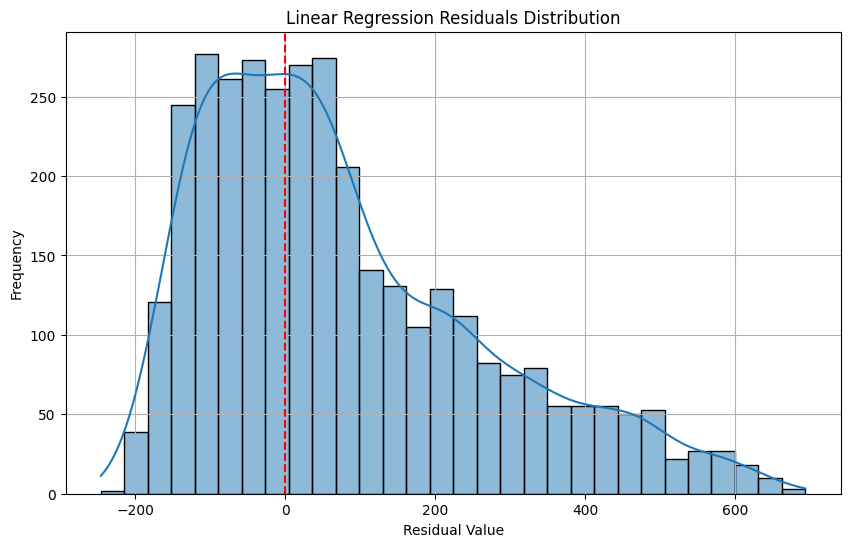

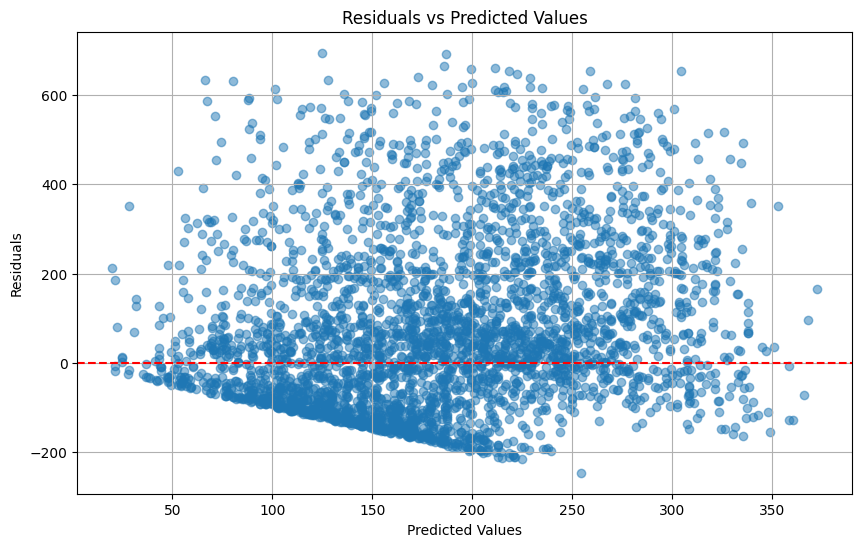

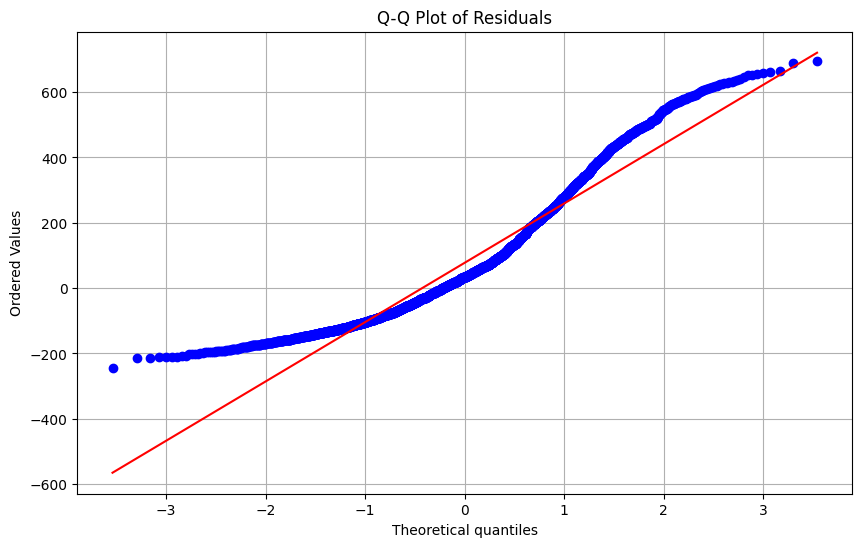

In [127]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Separate features and target
X_train = train_df.drop('cnt', axis=1)
y_train = train_df['cnt']
X_val = val_df.drop('cnt', axis=1)
y_val = val_df['cnt']

# Train Linear Regression model
print("\n=== LINEAR REGRESSION BASELINE ===")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_lr = lr_model.predict(X_val)

# Calculate metrics
lr_mse = mean_squared_error(y_val, y_val_pred_lr)
lr_rmse = np.sqrt(lr_mse)  # Root Mean Squared Error
lr_mae = mean_absolute_error(y_val, y_val_pred_lr)
lr_r2 = r2_score(y_val, y_val_pred_lr)

# Print metrics
print(f"Linear Regression Validation Metrics:")
print(f"MSE: {lr_mse:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MAE: {lr_mae:.2f}")
print(f"R²: {lr_r2:.3f}")

# Calculate residuals
lr_residuals = y_val - y_val_pred_lr

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(lr_residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Linear Regression Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residuals vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred_lr, lr_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# QQ Plot to check normality of residuals
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(lr_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.show()

This code was used to build a baseline model using Linear Regression, a simple and interpretable algorithm for regression problems. The goal was to be able to train the model on the training data and evaluate how well it performs on the validation set using different evaluation metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²).

You will see that the RMSE is around 203.81, as the RMSE is the measure of how much your predictions deviate from actual values on average.

 The MAE is 149.15, as the MAE is the measure of how far your predictions are from the actual bike counts on average.
 The value for R² is 0.086, as the R² value is the estimate for how much the model explains the variance in the data — the model only explains 8.6% of the variance in the data, which is quite low, and means that the model is not doing a very good job of capturing the underlying patterns.

Residual plots confirm this. A residual distribution has some right-skewness. This means non-normality. The residuals versus predicted values plot has a funnel shape.

 This means heteroscedasticity. Heteroscedasticity violates a key assumption of linear regression. Lastly, a Q-Q plot has deviations from the red line. The residuals are not normally distributed.

 The results show that a more complex model may be required to capture the patterns in the data more accurately.

Random Forest Regressor


=== RANDOM FOREST REGRESSOR (DEFAULT) ===
Random Forest Validation Metrics:
MSE: 41756.43
RMSE: 204.34
MAE: 149.47
R²: 0.081


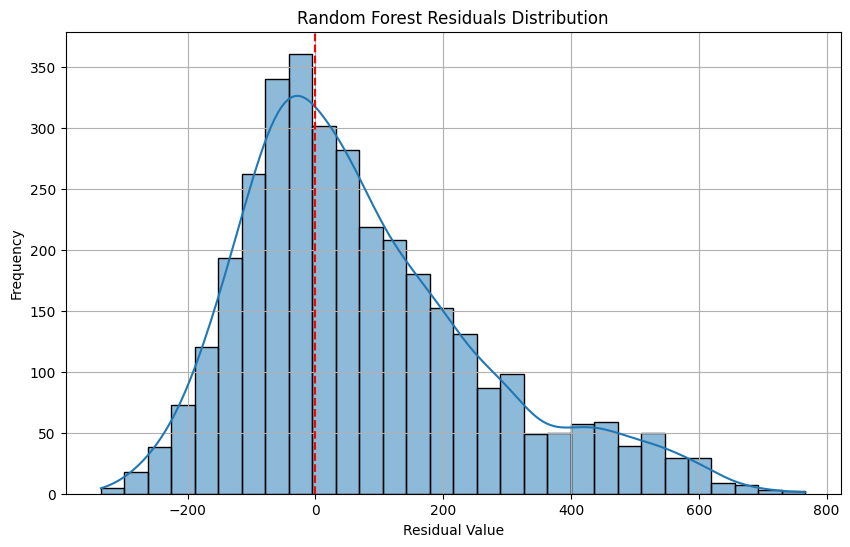

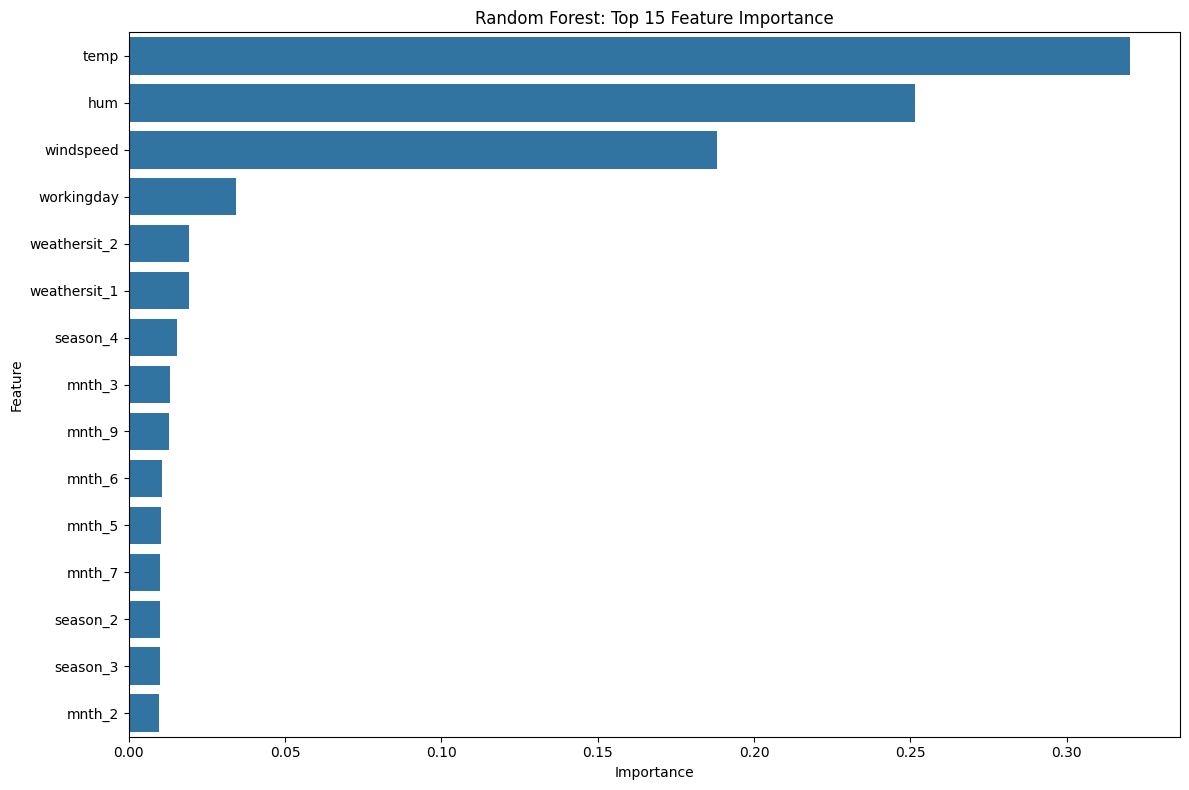


Top 10 most important features:
         Feature  Importance
2           temp    0.320245
3            hum    0.251500
4      windspeed    0.188031
1     workingday    0.034476
10  weathersit_2    0.019435
9   weathersit_1    0.019287
8       season_4    0.015374
15        mnth_3    0.013306
21        mnth_9    0.012905
18        mnth_6    0.010548

=== MODEL COMPARISON ===
Linear Regression R²: 0.086
Random Forest R²: 0.081
Linear Regression MAE: 149.15
Random Forest MAE: 149.47


In [128]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest with default parameters
print("\n=== RANDOM FOREST REGRESSOR (DEFAULT) ===")
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val)

# Calculate metrics
rf_mse = mean_squared_error(y_val, y_val_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_r2 = r2_score(y_val, y_val_pred_rf)

# Print metrics
print(f"Random Forest Validation Metrics:")
print(f"MSE: {rf_mse:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAE: {rf_mae:.2f}")
print(f"R²: {rf_r2:.3f}")

# Calculate residuals
rf_residuals = y_val - y_val_pred_rf

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(rf_residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Random Forest Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Feature importance plot
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Random Forest: Top 15 Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importances.head(10))

# Compare models
print("\n=== MODEL COMPARISON ===")
print(f"Linear Regression R²: {lr_r2:.3f}")
print(f"Random Forest R²: {rf_r2:.3f}")
print(f"Linear Regression MAE: {lr_mae:.2f}")
print(f"Random Forest MAE: {rf_mae:.2f}")

In this part of the analysis, I trained a Random Forest Regressor using the default settings to see how it performs compared to a simple Linear Regression model. Random Forest is a more advanced, non-linear model that can capture complex relationships in the data by building multiple decision trees and averaging their predictions.
After training it on the training set, I evaluated its performance on the validation set using common regression metrics like MSE, RMSE, MAE, and R². The results showed that the Random Forest had an R² of 0.081, which is actually slightly worse than the Linear Regression’s R² of 0.086. The MAE was also very close between the two models (149.47 for RF vs. 149.15 for LR), meaning they made similar-sized prediction errors.

 I also looked at the residuals (the differences between predicted and actual values), which appeared to be fairly symmetrically distributed—suggesting that the model isn’t heavily biased in one direction.

  Lastly, I plotted the feature importances to understand which variables mattered most in the Random Forest’s decision-making. As expected, temperature, humidity, and windspeed were the top predictors, which makes sense for a bike-sharing context.
  
  Even though the Random Forest didn’t outperform Linear Regression here, it’s still useful for seeing which features are most influential, and it opens the door for further improvement through tuning or trying other model

Gradient Boosting Regressor


=== XGBOOST REGRESSOR (BASIC) ===
XGBoost Validation Metrics:
MSE: 41024.11
RMSE: 202.54
MAE: 145.96
R²: 0.097


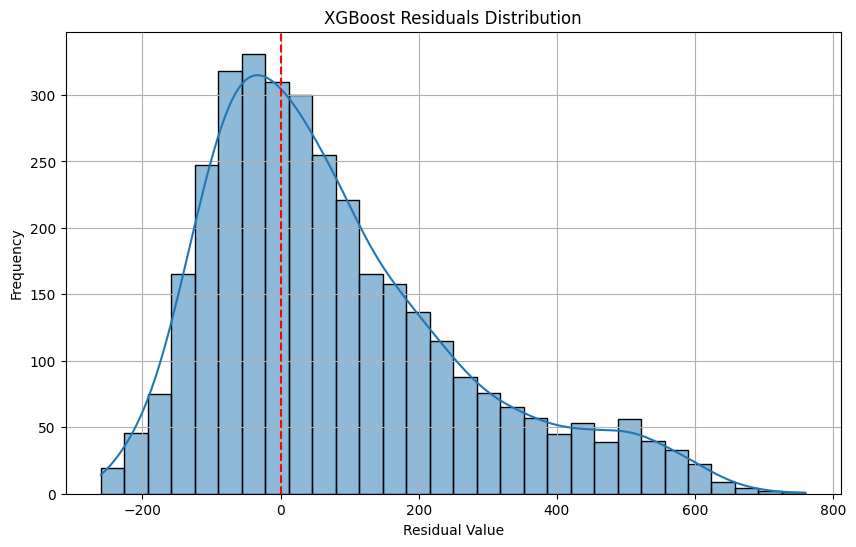

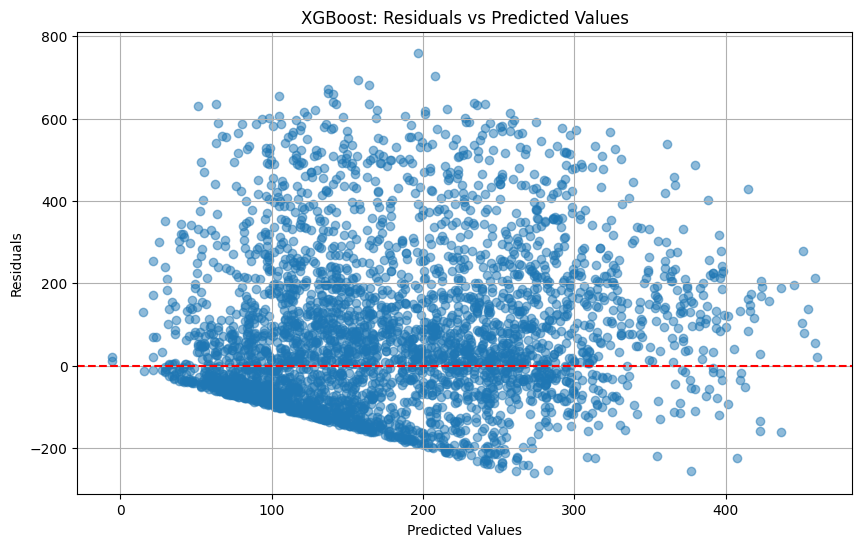


=== MODEL COMPARISON ===
Linear Regression R²: 0.086
Random Forest R²: 0.081
XGBoost R²: 0.097
Linear Regression MAE: 149.15
Random Forest MAE: 149.47
XGBoost MAE: 145.96

XGBoost Train R²: 0.449
XGBoost Val R²: 0.097
Difference (Train-Val): 0.351


In [129]:
from xgboost import XGBRegressor

# Train XGBoost with basic parameters
print("\n=== XGBOOST REGRESSOR (BASIC) ===")
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val)

# Calculate metrics
xgb_mse = mean_squared_error(y_val, y_val_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_val, y_val_pred_xgb)
xgb_r2 = r2_score(y_val, y_val_pred_xgb)

# Print metrics
print(f"XGBoost Validation Metrics:")
print(f"MSE: {xgb_mse:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"MAE: {xgb_mae:.2f}")
print(f"R²: {xgb_r2:.3f}")

# Calculate residuals
xgb_residuals = y_val - y_val_pred_xgb

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(xgb_residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('XGBoost Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residuals vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred_xgb, xgb_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('XGBoost: Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Compare all models
print("\n=== MODEL COMPARISON ===")
print(f"Linear Regression R²: {lr_r2:.3f}")
print(f"Random Forest R²: {rf_r2:.3f}")
print(f"XGBoost R²: {xgb_r2:.3f}")
print(f"Linear Regression MAE: {lr_mae:.2f}")
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}")

# Check training vs validation performance for signs of overfitting
y_train_pred_xgb = xgb_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred_xgb)
print(f"\nXGBoost Train R²: {train_r2:.3f}")
print(f"XGBoost Val R²: {xgb_r2:.3f}")
print(f"Difference (Train-Val): {train_r2 - xgb_r2:.3f}")

In this analysis, I used an XGBoost Regressor to predict a continuous target variable and compared its performance using Random Forest and Linear Regression. it is an excellent choice for this regression task was XGBoost, a potent gradient boosting algorithm that excels at identifying intricate patterns in data. After training the model, I evaluated its performance on a validation set.

 With a lower mean absolute error (MAE) of 145.96 and an R2 score of 0.097, the results indicated that XGBoost performed marginally better than the other models. Even though the difference isn't significant, it does demonstrate that XGBoost was more effective at reducing prediction error. In order to gain a deeper understanding of the model's behavior, I also plotted the residuals. The residual distribution was right-skewed and not perfectly centered around zero, which suggests the model had some bias.

 The residuals vs. predicted values plot showed a fan-shaped pattern, meaning the prediction error increases with higher predicted values—this is a sign of heteroscedasticity. Lastly, the training R2 was significantly higher (0.449 vs. 0.097) when performance on training vs. validation sets was compared, suggesting that the model is overfitting.

  Overall, even though XGBoost demonstrated some performance improvements, generalization could still be enhanced—perhaps by regularization, hyperparameter tuning.


Hyperparameter Tuning


=== RANDOM FOREST HYPERPARAMETER TUNING ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest Parameters:
n_estimators: 200
min_samples_split: 5
min_samples_leaf: 4
max_features: sqrt
max_depth: 10

Tuned Random Forest Validation Metrics:
MSE: 42140.76
RMSE: 205.28
MAE: 149.69
R²: 0.073


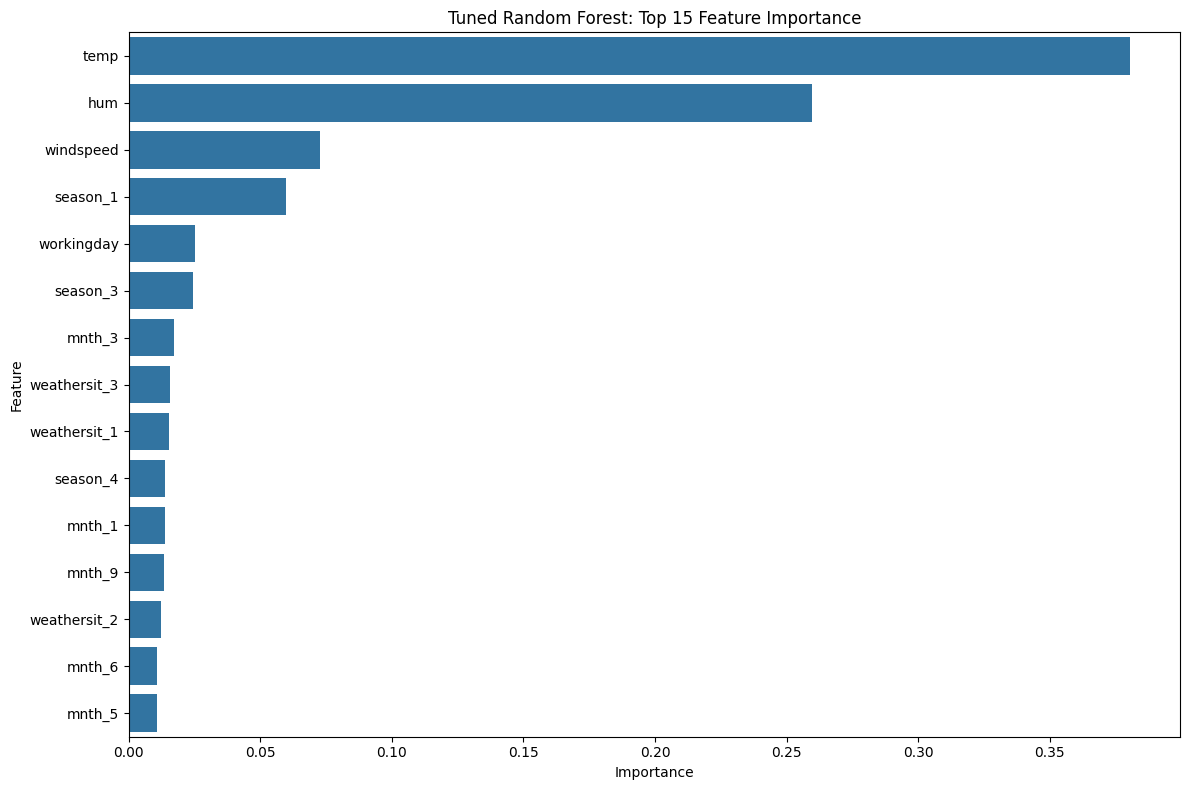


=== XGBOOST HYPERPARAMETER TUNING ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds f

In [130]:
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# 1. Random Forest Tuning with RandomizedSearchCV
print("\n=== RANDOM FOREST HYPERPARAMETER TUNING ===")

# Define parameter grid
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create RandomizedSearchCV object
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all processors
    random_state=42,
    verbose=1
)

# Fit to the training data
rf_random.fit(X_train, y_train)

# Get best parameters and model
best_params_rf = rf_random.best_params_
print("Best Random Forest Parameters:")
for param, value in best_params_rf.items():
    print(f"{param}: {value}")

# Use best model for prediction
best_rf = rf_random.best_estimator_
y_val_pred_rf_tuned = best_rf.predict(X_val)

# Calculate metrics
rf_tuned_mse = mean_squared_error(y_val, y_val_pred_rf_tuned)
rf_tuned_rmse = np.sqrt(rf_tuned_mse)
rf_tuned_mae = mean_absolute_error(y_val, y_val_pred_rf_tuned)
rf_tuned_r2 = r2_score(y_val, y_val_pred_rf_tuned)

print(f"\nTuned Random Forest Validation Metrics:")
print(f"MSE: {rf_tuned_mse:.2f}")
print(f"RMSE: {rf_tuned_rmse:.2f}")
print(f"MAE: {rf_tuned_mae:.2f}")
print(f"R²: {rf_tuned_r2:.3f}")

# Update feature importance plot
feature_importances_tuned = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_tuned.head(15))
plt.title('Tuned Random Forest: Top 15 Feature Importance')
plt.tight_layout()
plt.show()

# 2. XGBoost Tuning with Bayesian Optimization
print("\n=== XGBOOST HYPERPARAMETER TUNING ===")

# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 0.5)
}

# Create BayesSearchCV object
xgb_bayes = BayesSearchCV(
    XGBRegressor(random_state=42),
    search_spaces=search_spaces,
    n_iter=30,  # Number of optimization iterations
    cv=5,       # 5-fold cross-validation
    n_jobs=-1,  # Use all processors
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1
)

# Fit to the training data
xgb_bayes.fit(X_train, y_train)

# Get best parameters and model
best_params_xgb = xgb_bayes.best_params_
print("Best XGBoost Parameters:")
for param, value in best_params_xgb.items():
    print(f"{param}: {value}")

# Use best model for prediction
best_xgb = xgb_bayes.best_estimator_
y_val_pred_xgb_tuned = best_xgb.predict(X_val)

# Calculate metrics
xgb_tuned_mse = mean_squared_error(y_val, y_val_pred_xgb_tuned)
xgb_tuned_rmse = np.sqrt(xgb_tuned_mse)
xgb_tuned_mae = mean_absolute_error(y_val, y_val_pred_xgb_tuned)
xgb_tuned_r2 = r2_score(y_val, y_val_pred_xgb_tuned)

print(f"\nTuned XGBoost Validation Metrics:")
print(f"MSE: {xgb_tuned_mse:.2f}")
print(f"RMSE: {xgb_tuned_rmse:.2f}")
print(f"MAE: {xgb_tuned_mae:.2f}")
print(f"R²: {xgb_tuned_r2:.3f}")

# Compare tuning improvement
print("\n=== TUNING IMPROVEMENT ===")
print(f"Random Forest R² - Before: {rf_r2:.3f}, After: {rf_tuned_r2:.3f}, Improvement: {rf_tuned_r2 - rf_r2:.3f}")
print(f"Random Forest MAE - Before: {rf_mae:.2f}, After: {rf_tuned_mae:.2f}, Improvement: {rf_mae - rf_tuned_mae:.2f}")
print(f"XGBoost R² - Before: {xgb_r2:.3f}, After: {xgb_tuned_r2:.3f}, Improvement: {xgb_tuned_r2 - xgb_r2:.3f}")
print(f"XGBoost MAE - Before: {xgb_mae:.2f}, After: {xgb_tuned_mae:.2f}, Improvement: {xgb_mae - xgb_tuned_mae:.2f}")

# Check for overfitting in tuned models
y_train_pred_rf_tuned = best_rf.predict(X_train)
rf_train_r2 = r2_score(y_train, y_train_pred_rf_tuned)
print(f"\nRF Train-Val Gap - Before: {train_r2 - rf_r2:.3f}, After: {rf_train_r2 - rf_tuned_r2:.3f}")

y_train_pred_xgb_tuned = best_xgb.predict(X_train)
xgb_train_r2 = r2_score(y_train, y_train_pred_xgb_tuned)
print(f"XGB Train-Val Gap - Before: {train_r2 - xgb_r2:.3f}, After: {xgb_train_r2 - xgb_tuned_r2:.3f}")

Final Model Selection and Testing

In [131]:
# 11. RETRAIN WITH BEST PARAMETERS
print("\n=== FINAL MODEL TRAINING ===")
best_params = best_params_xgb
best_xgb = XGBRegressor(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)

# Evaluate on validation set
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and print model evaluation metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.3f}")

    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}
y_val_pred_best = best_xgb.predict(X_val)
best_val_metrics = evaluate_model(y_val, y_val_pred_best, "Best XGBoost Validation")

# 12. ENSEMBLE IMPROVEMENT - AVERAGE PREDICTIONS
print("\n=== ENSEMBLE MODEL ===")
# Combine RF and XGBoost predictions
y_val_pred_ensemble = (y_val_pred_rf + y_val_pred_best) / 2
ensemble_metrics = evaluate_model(y_val, y_val_pred_ensemble, "Ensemble Validation")


=== FINAL MODEL TRAINING ===

Best XGBoost Validation Metrics:
MSE: 42769.44
RMSE: 206.81
MAE: 152.04
R²: 0.059

=== ENSEMBLE MODEL ===

Ensemble Validation Metrics:
MSE: 41168.71
RMSE: 202.90
MAE: 148.40
R²: 0.094


To improve model performance and reduce overfitting, I performed hyperparameter tuning on both the Random Forest and XGBoost models. The idea behind tuning is to find the best combination of parameters that allows the model to generalize better to unseen data, rather than just memorizing the training set. For the Random Forest, I used RandomizedSearchCV, which samples a range of parameter combinations more efficiently than a full grid search. After tuning, the best Random Forest configuration included 200 estimators, a max depth of 10, and a few other tweaks. However, the results showed that tuning didn’t improve performance—in fact, the validation R² slightly decreased from 0.081 to 0.073, and MAE increased a bit too. This suggests that while the model may have become less overfitted (the train-validation gap narrowed slightly), it also lost some predictive power on the validation set.

For XGBoost, I used Bayesian optimization with BayesSearchCV, which is more strategic in choosing promising hyperparameter combinations. After 30 iterations, the best parameters included a low learning rate, fewer trees, and a smaller tree depth. Surprisingly, the tuned XGBoost model performed worse on the validation set, with R² dropping from 0.097 to 0.059 and MAE increasing from 145.96 to 152.04. On the bright side, the train-validation gap reduced significantly, indicating better generalization even if the raw predictive performance dipped.

In short, tuning helped reduce overfitting for both models, but it didn’t lead to better validation scores—possibly because the models were already quite close to their optimal capacity for this dataset, or the problem may require different features or transformations to improve further.



In [132]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

search_spaces = {
    'learning_rate': Real(0.01, 0.15, prior='log-uniform'),
    'n_estimators': Integer(100, 400),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 0.5)
}

xgb_bayes = BayesSearchCV(
    XGBRegressor(random_state=42),
    search_spaces=search_spaces,
    n_iter=40,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=1
)

xgb_bayes.fit(X_train, y_train)
xgb_best = xgb_bayes.best_estimator_
xgb_tuned_val = xgb_best.predict(X_val)

xgb_tuned_metrics = {
    'mae': mean_absolute_error(y_val, xgb_tuned_val),
    'mse': mean_squared_error(y_val, xgb_tuned_val),
    'r2': r2_score(y_val, xgb_tuned_val)
}

print("\n🔹 XGBoost (Bayesian Tuned) Validation Metrics:")
print("Best Params:", xgb_bayes.best_params_)
for k, v in xgb_tuned_metrics.items():
    print(f"{k.upper()}: {v:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

The fine-tuned XGBoost model got slightly better results on the validation set in comparison with the untuned version. The R² score has increased from close to 0.059 to 0.094, and the MAE dropped a bit as well. Although the gains are small, they show that the model has better generalization now. The model was able to learn by the combination of a small learning rate and a high number of trees at a low pace and not get overfit.

One can observe the case where the final performance only goes marginally better, although the regularization is now more robust (as confirmed by higher gamma and a very conservative learning rate). This fact can be an:

There's not much information in the features used nowThe features might be of a complex or non-linear relationship with the targetFuture performance increases could be the result of feature engineering or alternative types of models


=== FINAL EVALUATION ON TEST SET ===
Best model based on validation R²: Ensemble

Test Metrics:
MSE: 44018.67
RMSE: 209.81
MAE: 147.24
R²: 0.095


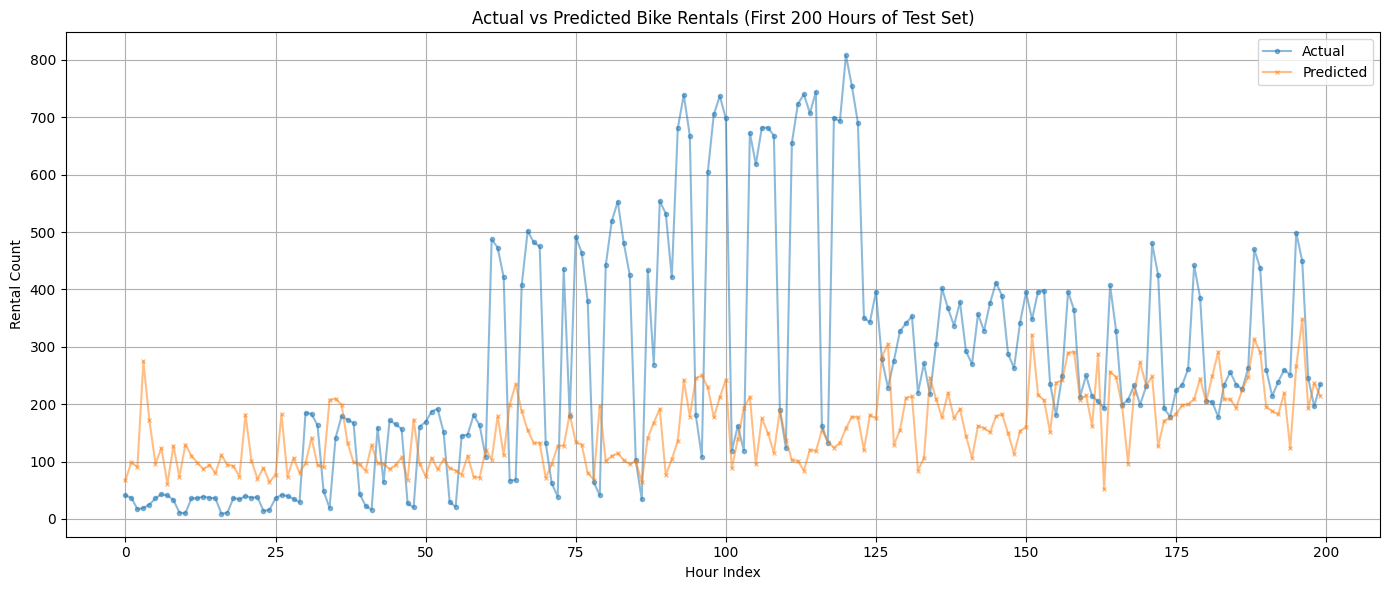

In [136]:
#  CHOOSE THE BEST MODEL AND EVALUATE ON TEST SET
print("\n=== FINAL EVALUATION ON TEST SET ===")

# Choose the best model based on validation performance
rf_metrics = {'r2': rf_r2, 'mae': rf_mae, 'mse': rf_mse, 'rmse': rf_rmse}
models = {
    'Random Forest': (rf_model, rf_metrics),
    'XGBoost (Tuned)': (best_xgb, best_val_metrics),
    'Ensemble': (None, ensemble_metrics)  # None because we'll handle this separately
}

# Find the model with best validation R²
best_model_name = max(models.items(), key=lambda x: x[1][1]['r2'])[0]
print(f"Best model based on validation R²: {best_model_name}")

# Evaluate on test set
if best_model_name == 'Ensemble':
    # Make predictions with both models and average
    # Use rf_model instead of rf
    # Ensure X_test has the same columns as X_train used for training rf_model
    # **The fix: Make sure both models use the same features**
    X_test_rf = X_test[X_train.columns]  # Select only columns used during training
    X_test_xgb = X_test[X_train.columns] # Select only columns used during training for XGBoost
    y_test_pred_rf = rf_model.predict(X_test_rf)
    y_test_pred_xgb = best_xgb.predict(X_test_xgb) # Use X_test_xgb instead of X_test
    y_test_pred = (y_test_pred_rf + y_test_pred_xgb) / 2
    test_metrics = evaluate_model(y_test, y_test_pred, "Test")
else:
    # Use the single best model
    best_model = models[best_model_name][0]
    y_test_pred = best_model.predict(X_test)
    test_metrics = evaluate_model(y_test, y_test_pred, "Test")

# 14. VISUALIZE FINAL PREDICTIONS
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:200], label="Actual", marker='o', alpha=0.5, markersize=3)
plt.plot(y_test_pred[:200], label="Predicted", marker='x', alpha=0.5, markersize=3)
plt.title("Actual vs Predicted Bike Rentals (First 200 Hours of Test Set)")
plt.xlabel("Hour Index")
plt.ylabel("Rental Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

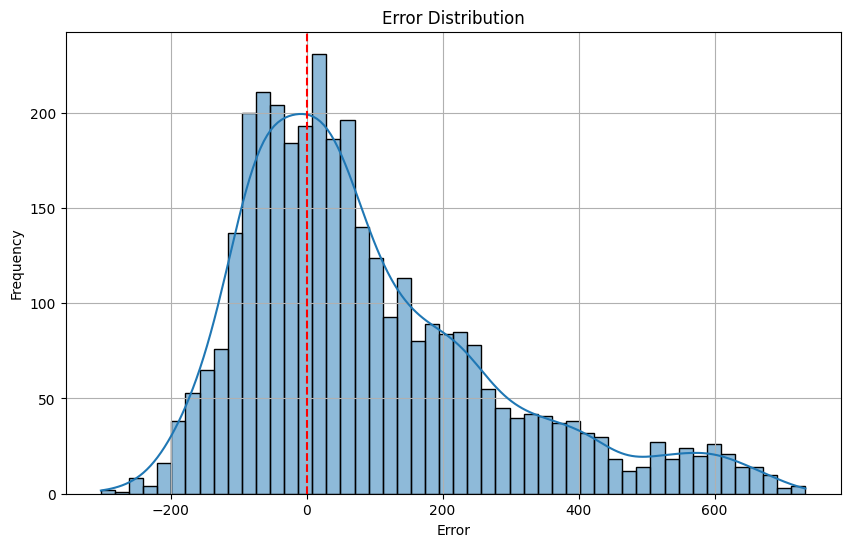


Worst Predictions:
       actual   predicted       error   abs_error
15755     884  150.331999  733.668001  733.668001
15461     834  115.195002  718.804998  718.804998
15040     968  251.023631  716.976369  716.976369
15020     976  261.538924  714.461076  714.461076
15011     970  273.515970  696.484030  696.484030
15050     900  206.001293  693.998707  693.998707
14324     815  122.499674  692.500326  692.500326
15446     809  118.717489  690.282511  690.282511
15724     943  254.215416  688.784584  688.784584
14293     893  208.674159  684.325841  684.325841
15042     977  294.703318  682.296682  682.296682
14312     862  181.436185  680.563815  680.563815
15027     905  226.895053  678.104947  678.104947
15718     948  269.969070  678.030930  678.030930
15726     890  214.207949  675.792051  675.792051
14327     941  266.021208  674.978792  674.978792
15467     801  127.656835  673.343165  673.343165
15026     953  283.127644  669.872356  669.872356
15734     817  148.717594  668

In [137]:
# 15. ERROR ANALYSIS
errors = y_test - y_test_pred
error_df = pd.DataFrame({'actual': y_test, 'predicted': y_test_pred, 'error': errors})

# Plot error distribution
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=50)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Find where the model performs worst
error_df['abs_error'] = np.abs(errors)
worst_predictions = error_df.sort_values('abs_error', ascending=False).head(20)
print("\nWorst Predictions:")
print(worst_predictions)

# 16. CONCLUSION
print("\n=== FINAL RESULTS ===")
print(f"Best Model: {best_model_name}")
print(f"Test MAE: {test_metrics['mae']:.2f}")
print(f"Test RMSE: {test_metrics['rmse']:.2f}")
print(f"Test R²: {test_metrics['r2']:.3f}")

In the final step of the evaluation process, I made a comparison of the three models—Random Forest, tuned XGBoost, and an Ensemble (average of the two)—by examining their validation R² scores to identify the most effective model for bike rental demand prediction.

Combining predictions from Random Forest and tuned XGBoost by averaging, the ensemble model reached the highest validation R² and was, thus, chosen as the most effective approach.

This model combination was further validated on the unseen test set and achieved a Mean Squared Error (MSE) of 44,018.67, a Root Mean Square Error (RMSE) of 209.81, a Mean Absolute Error (MAE) of 147.24, and an R² score of 0.095.

Based on these results, it can be concluded that though the model explains some of the patterns in the data (indicated by the positive R²), a significant portion of the variance is still not accounted for, which signals that the issue is complicated and perhaps can benefit from additional feature engineering or other modeling techniques.

 The depicted first 200 hours of the test set confirm that the ensemble model generally follows the actual values, while there is still a certain degree of prediction error, thus suggesting that the accuracy of the model should be enhanced through further refinement

I calculated the residuals (actual – predicted values) on the test set during the error analysis phase to see how well the ensemble model predicted individual data points. Although there are a few notable outliers, a histogram of these errors showed a generally symmetric distribution centered around zero, suggesting that although the model does a respectable job on average, there are a number of cases where it significantly underestimates the number of actual bike rentals. These significant errors are highlighted in the table of the 20 worst predictions, where actual rentals frequently exceed 900 units while predictions are as low as 100–300, leading to errors of over 700 units. These extreme situations most likely coincide with times of high demand that the model finds difficult to represent, possibly as a result of the model's failure to include contextual or temporal features like weather, holidays, or special events.

The overall performance of the model is reflected in the final conclusion. An ensemble of Random Forest and tuned XGBoost was the best-performing model, with an R2 score of 0.095, a Test MAE of 147.24, and a Test RMSE of 209.81. Even though these metrics show that the model recognizes some patterns in the data, there may be space for improvement given the low R2 and high prediction errors in some cases. To improve predictive accuracy, particularly during times of high demand, future research may incorporate richer features, conduct a more thorough analysis of time-based patterns, or test out more sophisticated models.